# IMPORTS

In [1]:
#Import necessary libraries
import numpy as np
import csv
import pandas as pd
import os
import torch.optim as optim
import torch
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import torch.nn as nn
import random
import heapq
import torch.nn.functional as F
import wandb
from torch.nn.utils import clip_grad_norm_
import warnings
warnings.filterwarnings("ignore")
import seaborn


In [2]:
#Check if CUDA is available
val=torch.cuda.is_available()
if val == 1:
    
 # If CUDA is available, use it as the device    
    device= torch.device('cuda')
else:
    
# If GPU is also unavailable, default to CPU
    device = torch.device('gpu')
    

In [3]:
# !wandb login f63b589f2c31fd6562d752168e172d22870ab562

# PREPROCESSING

In [4]:
# This function loads and preprocesses the dataset for training a sequence-to-sequence model.
def loadData(params):
    
    # Define path to dataset based on configuration
    dataset_path = params['dataset_path']
    
    # Open data files for training, validation, and testing
    tr_data = csv.reader(open(dataset_path + '/hin/hin_train.csv',encoding='utf8'))
    vl_data = csv.reader(open(dataset_path + '/hin/hin_valid.csv',encoding='utf8'))
    tt_data = csv.reader(open(dataset_path + '/hin/hin_test.csv',encoding='utf8'))
    
    # Initialize empty lists to store data
    tr_translations = []
    tt_words=[]
    vl_translations = []
    vl_words=[]
    tr_words =[]
    tt_translations = []
    pad=''
    start='$'
    end ='&'
    
    # Load training data
    train_data_list = list(tr_data)
    train_len = len(train_data_list)
    i = 0
    while i < train_len:
        pair = train_data_list[i]
        tr_words.append(pair[0] + end)
        tr_translations.append(start + pair[1] + end)
        i += 1  
    
    # Load validation data 
    i=0
    val_data_list = list(vl_data)
    val_len = len(val_data_list)
    while i < val_len :
        pair=val_data_list[i]
        vl_words.append(pair[0]+end)
        vl_translations.append(start+pair[1]+end)
        i+=1
    
    # Load validation data   
    i=0
    test_data_list = list(tt_data)
    test_len = len(test_data_list)
    while i < test_len :
        pair=test_data_list[i]
        tt_words.append(pair[0]+end)
        tt_translations.append(start+pair[1]+end)
        i+=1   
        
 
    # Convert lists to NumPy arrays for better performance
    tt_words =np.array(tt_words)
    tr_translations = np.array(tr_translations)
    vl_translations =np.array(vl_translations)
    tr_words = np.array(tr_words)
    tt_translations = np.array(tt_translations)
    vl_words =np.array(vl_words)
    
    
    # Build input and output vocabularies
    output_vocab,input_vocab = set() , set()
    
    # Add characters from train_words to input_vocab
    i = 0
    word_len=len(tr_words)
    while i < word_len :
        word = tr_words[i]
        char_index = 0
        while char_index < len(word):
            character = word[char_index]
            input_vocab.add(character)
            char_index += 1
        i += 1         
    
    # Add characters from val_words to input_vocab
    i = 0
    word_len=len(vl_words)
    while i < word_len :
        word = vl_words[i]
        char_index = 0
        while char_index < len(word):
            character = word[char_index]
            input_vocab.add(character)
            char_index += 1
        i += 1
        
    # Add characters from test_words to input_vocab
    i = 0
    word_len=len(tt_words)
    while i < word_len :
        word = tt_words[i]
        char_index = 0
        while char_index < len(word):
            character = word[char_index]
            input_vocab.add(character)
            char_index += 1
        i += 1
    
    # Add characters from train_translations, val_translations, and test_translations to output_vocab
    i = 0
    word_len=len(tr_translations)
    while i < word_len :
        word = tr_translations[i]
        char_index = 0
        while char_index < len(word):
            character = word[char_index]
            output_vocab.add(character)
            char_index += 1
        i += 1
        
    i = 0
    word_len=len(vl_translations)
    while i < word_len :
        word = vl_translations[i]
        char_index = 0
        while char_index < len(word):
            character = word[char_index]
            output_vocab.add(character)
            char_index += 1
        i += 1
        
    i = 0
    word_len=len(tt_translations)
    while i < word_len :
        word = tt_translations[i]
        char_index = 0
        while char_index < len(word):
            character = word[char_index]
            output_vocab.add(character)
            char_index += 1
        i += 1
    # Remove special tokens from output_vocab
    output_vocab.remove(start)
    input_vocab.remove(end)
    output_vocab.remove(end)
    
    # Sort vocabularies and add special tokens
    output_vocab= [pad, start, end] + list(sorted(output_vocab))
    input_vocab = [pad, start, end] + list(sorted(input_vocab))
            
    # Create index mappings for vocabularies
    output_index,input_index = {char: idx for idx, char in enumerate(output_vocab)},{char: idx for idx, char in enumerate(input_vocab)}
    output_index_rev,input_index_rev = {idx: char for char, idx in output_index.items()},{idx: char for char, idx in input_index.items()}
    
    # Determine maximum sequence length
    max_len = max(max([len(word) for word in np.hstack((tr_words, tt_words, vl_words))]), max([len(word) for word in np.hstack((tr_translations, vl_translations, tt_translations))]))
    
    # Prepare preprocessed data dictionary
    preprocessed_data = {
        'SOS' : start,
        'EOS' : end,
        'PAD' : pad,
        'train_words' : tr_words,
        'train_translations' : tr_translations,
        'val_words' : vl_words,
        'val_translations' : vl_translations,
        'test_words' : tt_words,
        'test_translations' : tt_translations,
        'max_enc_len' : max([len(word) for word in np.hstack((tr_words, tt_words, vl_words))]),
        'max_dec_len' : max([len(word) for word in np.hstack((tr_translations, vl_translations, tt_translations))]),
        'max_len' : max_len,
        'input_index' : input_index,
        'output_index' : output_index,
        'input_index_rev' : input_index_rev,
        'output_index_rev' : output_index_rev
    }
    return preprocessed_data

In [5]:
def create_tensor(preprocessed_data):
    
    # Extract max sequence length and the number of training examples
    prop_data=preprocessed_data['max_len']
    leng=len(preprocessed_data['train_words'])
    d_type='int64'
    
    # Initialize arrays for data
    input_data = np.zeros((prop_data,leng), dtype = d_type)
    output_data = np.zeros((prop_data,leng), dtype = d_type)
    leng=len(preprocessed_data['val_words'])
    vl_input_data = np.zeros((prop_data,leng), dtype = d_type)
    vl_output_data = np.zeros((prop_data,leng), dtype = d_type)
    leng=len(preprocessed_data['test_words'])
    tt_input_data = np.zeros((prop_data,leng), dtype = d_type)
    tt_output_data = np.zeros((prop_data,leng), dtype = d_type)
    
    # Fill in training data arrays
    idx = 0
    while idx < len(preprocessed_data['train_words']):
        w = preprocessed_data['train_words'][idx]
        t = preprocessed_data['train_translations'][idx]

        i = 0
        while i < len(w):
            char = w[i]
            input_data[i, idx] = preprocessed_data['input_index'][char]
            i += 1

        i = 0
        while i < len(t):
            char = t[i]
            output_data[i, idx] = preprocessed_data['output_index'][char]
            i += 1
        idx += 1            
        

    # Fill in validation data arrays        
    idx = 0
    while idx < len(preprocessed_data['val_words']):
        w = preprocessed_data['val_words'][idx]
        t = preprocessed_data['val_translations'][idx]

        i = 0
        while i < len(w):
            char = w[i]
            vl_input_data[i, idx] = preprocessed_data['input_index'][char]
            i += 1

        i = 0
        while i < len(t):
            char = t[i]
            vl_output_data[i, idx] = preprocessed_data['output_index'][char]
            i += 1
        idx += 1            
        
    # Fill in test data arrays        
    idx = 0
    while idx < len(preprocessed_data['test_words']):
        w = preprocessed_data['test_words'][idx]
        t = preprocessed_data['test_translations'][idx]

        i = 0
        while i < len(w):
            char = w[i]
            tt_input_data[i, idx] = preprocessed_data['input_index'][char]
            i += 1

        i = 0
        while i < len(t):
            char = t[i]
            tt_output_data[i, idx] = preprocessed_data['output_index'][char]
            i += 1
        idx += 1            
        
            
    # Convert NumPy arrays to PyTorch tensors        
    output_data=torch.tensor(output_data, dtype = torch.int64)
    input_data = torch.tensor(input_data,dtype = torch.int64)
    vl_output_data=torch.tensor(vl_output_data, dtype = torch.int64)
    vl_input_data = torch.tensor(vl_input_data,dtype = torch.int64)
    tt_output_data=torch.tensor(tt_output_data, dtype = torch.int64)
    tt_input_data= torch.tensor(tt_input_data,dtype = torch.int64)
    
    #Store tensors in a dictionary
    tensors = {
        'input_data' : input_data,
        'output_data' : output_data,
        'val_input_data' : vl_input_data,
        'val_output_data' : vl_output_data, 
        'test_input_data' : tt_input_data,
        'test_output_data' : tt_output_data
    }
    return tensors

# ATTENTION

In [6]:

class Attention(nn.Module):
    
    # Initialize the Attention module
    def __init__(self, hidden_size):
        val=hidden_size
        super(Attention, self).__init__()
        self.hidden_size = val
        
    def dot_score(self,hidden_state, encoder_states):
        # Calculate the dot product attention scores
        cal = torch.sum(hidden_state * encoder_states, dim=2)
        return cal
    
    def forward(self, hidden, encoder_outputs):
        # Compute attention weights using dot product scoring and softmax
        cal = F.softmax(self.dot_score(hidden, encoder_outputs).t(), dim=1).unsqueeze(1)
        return cal

# ENCODER RG

In [7]:
class Encoder_Attention(nn.Module):
    
    def __init__(self, params, preprocessed_data):
        hd='hidden_size'
        dp='dropout'
        
        # Initialize the Encoder_Attention module
        super(Encoder_Attention, self).__init__() 
        self.bi_directional,self.cell_type = params['bi_dir'],params['cell_type']
        leng=len(preprocessed_data['input_index'])
        
        # Define dropout layer and embedding layer
        self.dropout,self.embedding = nn.Dropout(params[dp]),nn.Embedding(leng, params[es])
        self.hidden_size = params[hd]
        val=self.cell_type
        nm='num_layers_enc'
        es='embedding_size' 
        
        # Initialize RNN cell based on cell_type
        if val == 'GRU':
            self.cell = nn.GRU(params[es], params[hd], params[nm], dropout = params[dp], bidirectional = self.bi_directional)
        if val == 'RNN':
            self.cell = nn.RNN(params[es], params[hd], params[nm], dropout = params[dp], bidirectional = self.bi_directional)
        
    def forward(self, x):
        # Perform forward pass of the Encoder_Attention module
        encoder_states, hidden = self.cell(self.dropout(self.embedding(x)))
        
        # If bidirectional, concatenate forward and backward RNN outputs
        val=self.bi_directional
        if val:
            encoder_states = encoder_states[:, :, :self.hidden_size] + encoder_states[:, : ,self.hidden_size:]
        return encoder_states, hidden

# DECODER RG

In [8]:
class Decoder_Attention(nn.Module):
    def __init__(self, params, preprocessed_data):
        
        # Initialize the Decoder_Attention module
        super(Decoder_Attention, self).__init__()
        dp = 'dropout'
        
        # Define dropout layer and embedding layer
        self.dropout = nn.Dropout(params[dp])
        ct,nm = 'cell_type','num_layers_dec'
        self.num_layers,self.cell_type= params[nm] , params[ct]
        es = 'embedding_size'
        leng = len(preprocessed_data['output_index'])
        self.embedding = nn.Embedding(leng, params[es])
        hs = 'hidden_size'
        val=self.cell_type
        
        # Initialize RNN cell based on cell_type
        if val == 'GRU':
            self.cell = nn.GRU(params[es], params[hs], self.num_layers, dropout = params[dp])
        if val == 'RNN':
            self.cell = nn.RNN(params[es], params[hs], self.num_layers, dropout = params[dp])
        val = params[hs] * 2
        leng = len(preprocessed_data['output_index'])
        self.fc , self.concat = nn.Linear(params[hs], leng),nn.Linear(val, params[hs])
        self.log_softmax , self.attn = nn.LogSoftmax(dim=1),Attention(params[hs])

    def forward(self, x, encoder_states, hidden, cell):
        
        # Perform forward pass of the Decoder_Attention module
        # Embed input token (unsqueeze to add batch dimension)
        outputs, (hidden) = self.cell(self.dropout(self.embedding(x.unsqueeze(0))), hidden)
        attention_weights =self.attn(outputs,encoder_states)
        context = attention_weights.bmm(encoder_states.transpose(0,1))
        return self.log_softmax(self.fc(torch.tanh(self.concat(torch.cat((outputs.squeeze(0), context.squeeze(1)), 1))))), hidden, attention_weights.squeeze(1)

# SEQ 2 SEQ RG

In [9]:
# Define a sequence-to-sequence model with attention mechanism
class Seq2Seq_Attention(nn.Module):
    # Initialize the Seq2Seq_Attention module
    def __init__(self, encoder, decoder, params,  preprocessed_data):
        super(Seq2Seq_Attention, self).__init__()
        # Extract necessary parameters from the params dictionary
        nm='num_layers_dec'
        leng=len(preprocessed_data['output_index'])
        self.output_index_len = leng
        tf= 'teacher_fr'
        self.tfr = params[tf]
        self.num_layers_dec = params[nm]
        
        # Set encoder and decoder modules
        self.encoder  = encoder
        self.decoder  = decoder 
        
        
    def forward(self, source, target):
        # Perform forward pass of the Seq2Seq_Attention module
        
        # Initialize decoder input (start token)
        x = target[0,:]
        
        # Encode the source sequence using the encoder
        encoder_op, hidden = self.encoder(source)
        
        # Initialize output tensor for predictions
        outputs = torch.zeros(target.shape[0], source.shape[1], self.output_index_len)
        outputs=outputs.to(device)
        
        # Limit decoder hidden state to the specified number of layers
        hidden =  hidden[:self.decoder.num_layers]
        t = 1
        while t < target.shape[0] :  
            # Perform decoding step using the decoder module
            output, hidden, _ = self.decoder(x, encoder_op, hidden, None)
            # Determine the next input token based on teacher forcing ratio
            best_guess = output.argmax(1)
            # Store the output predictions
            outputs[t] = output
            x = best_guess if random.random() >= self.tfr else target[t]
            t+=1
        # Return the predicted outputs from the decoder    
        return outputs

# ENCODER LSTM

In [10]:
# Define an Encoder module with attention using LSTM
class Encoder_Attention_LSTM(nn.Module):
    ct='cell_type'
    bi='bi_dir'
    def __init__(self, params, preprocessed_data):
        
        #Initialize the Encoder_Attention_LSTM module
        super(Encoder_Attention_LSTM, self).__init__()
        self.cell_type = params['cell_type']
        self.bi_directional = params['bi_dir']
        es='embedding_size'
        leng=len(preprocessed_data['input_index'])
        self.embedding = nn.Embedding(leng, params[es])
        dp='dropout'
        hs='hidden_size'
        self.hidden_size = params[hs]
        nm='num_layers_enc'
        self.dropout = nn.Dropout(params[dp])
        
        # Initialize LSTM cell
        self.cell = nn.LSTM(params[es], params[hs], params[nm], dropout = params[dp], bidirectional = self.bi_directional)

    def forward(self, x):
        # Perform forward pass of the Encoder_Attention_LSTM module
        
        # Embed the input sequence
        encoder_states, (hidden, cell) = self.cell(self.dropout(self.embedding(x)))
        
        # If bidirectional, concatenate the states from both directions
        val=self.bi_directional
        if val:
            encoder_states = encoder_states[:, :, :self.hidden_size] + encoder_states[:, : ,self.hidden_size:]
        
        # Return encoder, hidden and cell states    
        return encoder_states, hidden, cell

# DECODER LSTM

In [11]:
# Define a Decoder module with attention using LSTM
class Decoder_Attention_LSTM(nn.Module):
    def __init__(self, params, preprocessed_data):
        
        # Initialize the Decoder_Attention_LSTM module
        super(Decoder_Attention_LSTM, self).__init__()
        nm='num_layers_dec'
        dp='dropout'
        
        # Set up dropout layer
        self.dropout = nn.Dropout(params[dp])
        self.num_layers = params[nm]
        ot='output_index'
        
        # Initialize embedding layer based on output vocabulary size and embedding size
        leng=len(preprocessed_data[ot])
        es='embedding_size'
        self.embedding = nn.Embedding(leng, params[es])
        hs='hidden_size'
        
        # Initialize LSTM cell for decoding
        self.cell = nn.LSTM(params[es], params[hs], self.num_layers, dropout = params[dp])
        val=params[hs] * 2
        
        # Initialize attention mechanism and log softmax layer
        leng=len(preprocessed_data[ot])
        self.concat , self.fc = nn.Linear(val, params[hs]),nn.Linear(params[hs], leng)
        self.attn,self.log_softmax  = Attention(params[hs]),nn.LogSoftmax(dim=1)

    def forward(self, x, encoder_states, hidden, cell):
        # Perform forward pass of the Decoder_Attention_LSTM module
        
        # Embed the input token
        outputs, (hidden, cell) = self.cell(self.dropout(self.embedding(x.unsqueeze(0))), (hidden, cell))
        
        # Apply attention to the LSTM outputs and encoder states
        context = self.attn(outputs, encoder_states).bmm(encoder_states.transpose(0, 1))
        
        return self.log_softmax(self.fc(torch.tanh(self.concat(torch.cat((outputs.squeeze(0), context.squeeze(1)), 1))))), hidden, cell, self.attn(outputs, encoder_states).squeeze(1)

# SEQ 2 SEQ LSTM

In [12]:
# Define a Sequence-to-Sequence model with attention using LSTM
class Seq2Seq_Attention_LSTM(nn.Module):
    def __init__(self, encoder, decoder, params,  preprocessed_data):
        nm='num_layers_dec'
        super(Seq2Seq_Attention_LSTM, self).__init__()
        leng=len(preprocessed_data['output_index'])
        
        # Extract parameters from params and preprocessed_data
        self.encoder  = encoder
        self.decoder  = decoder
        self.output_index_len = leng
        fr='teacher_fr'
        self.num_layers_dec = params[nm]
        self.tfr = params[fr]

    def forward(self, source, target):
         # Perform the forward pass of the Seq2Seq_Attention_LSTM module
        
        # Initialize the first input token (start of sequence) for decoding
        x = target[0,:]# Start with the first token in the target sequence
        
        # Encode the source sequence using the encoder
        encoder_op, hidden, cell = self.encoder(source)
        
        # Prepare a tensor to store the decoder outputs
        outputs = torch.zeros(target.shape[0], source.shape[1], self.output_index_len)
        outputs=outputs.to(device)
                
        # Restrict hidden and cell states to the decoder's number of layers
        hidden =  hidden[:self.decoder.num_layers]
        cell = cell[:self.decoder.num_layers]
        
        t=1
        while t< target.shape[0]:
            # Perform decoding step with attention using the decoder
            output, hidden, cell, _ = self.decoder(x, encoder_op, hidden, cell)
            
            # Determine the next input token based on teacher forcing ratio
            best_guess = output.argmax(1)
            
            # Store the decoder output in the outputs tensor
            outputs[t] = output
            x = best_guess if random.random() >= self.tfr else target[t]
            t+=1
        # Return the predicted outputs from the decoder for each time step    
        return outputs

# GET OPTIMIZERS

In [13]:
# Function to get the optimizer based on specified parameters
def get_optim(model, params):
    # Extract the optimizer type from params and convert to lowercase
    val = params['optimizer'].lower()
    
    if  val== 'sgd':
        # Use Stochastic Gradient Descent (SGD) optimizer
        opt = optim.SGD(model.parameters(), lr = params['learning_rate'], momentum = 0.9)
    
    if val == 'adagrad':
        # Use adagrad optimizer
        opt = optim.Adagrad(model.parameters(), lr = params['learning_rate'], lr_decay = 0, weight_decay = 0, initial_accumulator_value = 0, eps = 1e-10)
    
    if val == 'adam':
        # Use adam optimizer
        opt = optim.Adam(model.parameters(), lr = params['learning_rate'], betas = (0.9, 0.999), eps = 1e-8)
    
    if val == 'rmsprop':
        # Use rmsprop optimizer
        opt = optim.RMSprop(model.parameters(), lr = params['learning_rate'], alpha = 0.99, eps = 1e-8)
    return opt

# BEAM SEARCH

In [14]:
#Performs beam search using the specified model to predict a sequence for the input word.
def beam_search(model, word, preprocessed_data, params, bw = 1, lp = 0.6): 
    # Prepare input sequence for encoding
    val=preprocessed_data['max_len']+1
    data = np.zeros((val, 1), dtype=np.int32)
    idx = 0
    while idx < len(word):
        char = word[ idx ]
        data[ idx , 0 ] = preprocessed_data['input_index'][char]
        idx += 1
        
    # Append end-of-sequence token to the input sequence    
    data[idx , 0] = preprocessed_data['input_index'][preprocessed_data['EOS']]
    data = torch.tensor(data, dtype=torch.int32).to(device)
    
    # Perform encoding using the model
    with torch.no_grad():
        val=params['cell_type']
        if  val != 'LSTM':
            outputs, hidden = model.encoder(data)
        else:
            outputs, hidden, cell = model.encoder(data)
            cell =  cell[:params['num_layers_dec']]
     
    # Prepare for beam search initialization
    hidden =  hidden[:params['num_layers_dec']]
    out_reshape = np.array(preprocessed_data['output_index'][preprocessed_data['SOS']]).reshape(1,)
    hidden_par = hidden.unsqueeze(0)
    initial_sequence = torch.tensor(out_reshape).to(device)
    beam = [(0.0, initial_sequence, hidden_par)]
    
    # Perform beam search
    i = 0
    leng=len(preprocessed_data['output_index'])
    while i < leng:
        candidates = []
        index = 0
        # Expand each beam in the current step
        while index < len(beam):
            score, seq, hidden = beam[index]
            val=seq[-1].item() == preprocessed_data['output_index'][preprocessed_data['EOS']]
            
            # Check if the sequence ends with the end-of-sequence token
            if val:
                candidates.append((score, seq, hidden))
                index+=1
                continue
            reshape_last = np.array(seq[-1].item()).reshape(1,)
            hdn = hidden.squeeze(0)
            x = torch.tensor(reshape_last).to(device)
            val=params['cell_type']
            if  val!= 'LSTM':
                output, hidden, _ = model.decoder(x, outputs, hdn, None)
            else:
                output, hidden, cell, _ = model.decoder(x, outputs, hdn, cell)
            
            # Apply softmax to the output and select top-k tokens
            val=F.softmax(output, dim=1)
            topk_probs, topk_tokens = torch.topk(val, k=bw)
            
            # Generate new candidate sequences
            ii = 0
            while ii < len(topk_probs[0]):
                prob = topk_probs[0][ii]
                token = topk_tokens[0][ii]
                new_seq = torch.cat((seq, token.unsqueeze(0)), dim=0)
                ln_ns = len(new_seq)
                ln_pf = ((ln_ns - 1) / 5)
                candidate_score = score + torch.log(prob).item() / (ln_pf ** lp)
                candidates.append((candidate_score, new_seq, hidden.unsqueeze(0)))
                ii += 1
            index += 1
        # Select the top-beam-width candidates
        beam = heapq.nlargest(bw, candidates, key=lambda x: x[0])
        i += 1
    
    # Retrieve the best sequence from the final beams    
    m = max(beam, key=lambda x: x[0]) 
    _, best_sequence, _ = m
    # Convert the best sequence to the predicted output
    prediction = ''.join([preprocessed_data['output_index_rev'][token.item()] for token in best_sequence[1:]])    
    
    # Return the predicted sequence (excluding the EOS token)                                                                                                     
    return prediction[:-1]


# TRAINING FUNCTION

In [15]:
# Function to train the model
def train(model, crit, optimizer, preprocessed_data, tensors, params):
    val=1
    bs='batch_size'
    # Split the input and output data into batches
    tr_result = torch.split(tensors['output_data'], params[bs], dim = val)
    tr_data=torch.split(tensors['input_data'], params[bs], dim = val)
    vl_result= torch.split(tensors['val_output_data'], params[bs], dim=val)
    vl_data=torch.split(tensors['val_input_data'], params[bs], dim=val)
    
    # Loop through epochs
    epoch = 0
    while epoch < params['num_epochs'] :
        epoch +=1
        
        # Initialize counters for metrics
        correct_prediction,total_loss,total_words = 0,0,0
        model.train()
        leng=len(tr_data)
        
        # Use tqdm for progress visualization during training
        val='Training'
        with tqdm(total = leng, desc = val) as pbar:
            index = 0
            lenn = len(tr_data)
            
            # Loop through each batch in training data
            while index < lenn:
                # Move input and target data to device (e.g., GPU)
                y = tr_result[index]
                x = tr_data[index] 
                inp_data = x.to(device)
                target= y.to(device) 
                optimizer.zero_grad()
                output = model(inp_data, target)
                
                # Reshape target and output for loss calculation
                target = target.reshape(-1)
                output = output.reshape(-1, output.shape[2])
                
                # Create a mask to ignore padding tokens
                pad_mask = (target != preprocessed_data['output_index'][preprocessed_data['PAD']])
                output = output[pad_mask]
                target = target[pad_mask]
                
                # Compute loss and perform backpropagation
                loss = crit(output, target)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
                optimizer.step()
                
                # Update metrics
                total_loss = total_loss +loss.item()
                total_words = total_words + target.size(0)
                correct_prediction = correct_prediction + torch.sum(torch.argmax(output, dim=1) == target).item()

                index += 1
                pbar.update(1)
        
        # Calculate training accuracy and loss
        cal=correct_prediction / total_words
        train_accuracy = cal * 100
        len_train=len(tr_data)
        train_loss = total_loss / len_train
        model.eval()
        
        # Evaluate model on validation data
        with torch.no_grad():
            val_total_words,val_correct_pred,val_total_loss = 0,0,0
            with tqdm(total = len(vl_data), desc = 'Validation') as pbar:
                
                index = 0
                lenn=len(vl_data)
                # Loop through each batch in validation data
                while index < lenn:
                    
                    y_val =vl_result[index]
                    x_val= vl_data[index]
                    # Move validation input and target data to device
                    inp_data_val = x_val.to(device)
                    target_val=y_val.to(device)
                    
                    # Forward pass through the model for validation
                    output_val = model(inp_data_val, target_val)
                    target_val = target_val.reshape(-1)
                    output_val = output_val.reshape(-1, output_val.shape[2])
                    
                    # Create mask to ignore padding tokens
                    pad_mask = (target_val != preprocessed_data['output_index'][preprocessed_data['PAD']])
                    output_val = output_val[pad_mask]
                    target_val = target_val[pad_mask]
                    
                    # Calculate validation loss and metrics
                    val_loss = crit(output_val, target_val)
                    val_total_loss = val_total_loss+ val_loss.item()
                    val_total_words = val_total_words+ target_val.size(0)
                    val_correct_pred = val_correct_pred+ torch.sum(torch.argmax(output_val, dim=1) == target_val).item()
                    index += 1
                    pbar.update(1)
            # Calculate validation accuracy and loss        
            cal=val_correct_pred / val_total_words        
            val_accuracy = cal * 100
            lengg=len(vl_data)
            val_loss = val_total_loss / lengg
            
            # Evaluate model using beam search and calculate word-level accuracy
            correct_prediction = 0
            total_words = len(preprocessed_data['val_words'])
            with tqdm(total = total_words, desc = 'Beam') as pbar_:
                index = 0
                # Loop through each word in validation set for beam search evaluation
                while index < len(preprocessed_data['val_words']):
                    word, translation = preprocessed_data['val_words'][index], preprocessed_data['val_translations'][index]
                    ans = beam_search(model, word, preprocessed_data, params, params['beam_width'], params['length_penalty'])
                    val= translation[1:-1]
                    # Check if beam search translation matches reference translation
                    if ans == val:
                        correct_prediction = correct_prediction +1

                    index += 1
                    pbar_.update(1)
        # Calculate word-level accuracy using beam search            
        cal=correct_prediction / total_words
        val_accuracy_beam = cal * 100
        
        # Print and log results
        print(f'''Epoch : {epoch}
              Train Accuracy Char Level : {train_accuracy:.4f}, Train Loss : {train_loss:.4f}
              Validation Accuracy Char Level : {val_accuracy:.4f}, Validation Loss : {val_loss:.4f}
              Validation Accuracy Word Level : {val_accuracy_beam:.4f},  Correctly predicted : {correct_prediction}/{total_words}''')
        if params['w_log']:
            wandb.log(
                    {
                        'epoch': epoch,
                        'training_loss' : train_loss,
                        'training_accuracy_char' : train_accuracy,
                        'validation_loss' : val_loss,
                        'validation_accuracy_char' : val_accuracy,
                        'validation_accuracy_word' : val_accuracy_beam,
                        'correctly_predicted' : correct_correct_predictionpred
                    }
                )
    # Return the trained model and validation accuracies    
    return model, val_accuracy, val_accuracy_beam

# Question 5

## HYPERPARAMETERS

In [16]:
#Passing parameters
params = {
#     'dataset_path' : r'C:\Users\gragh\OneDrive\Desktop\Codes\CS6910 DL\Assignment 3\DataSet\aksharantar_sampled',
    'language' : 'hin',
    'dataset_path' : '/kaggle/input/dl-ass-3/aksharantar_sampled',
    'embedding_size': 256,
    'hidden_size': 512,
    'num_layers_enc': 3,
    'num_layers_dec': 3,
    'cell_type': 'LSTM',
    'dropout': 0.3,
    'optimizer' : 'adagrad',
    'learning_rate': 0.01,
    'batch_size': 32,
    'num_epochs': 10,
    'teacher_fr' : 0.7,
    'length_penalty' : 0.6,
    'beam_width': 1,
    'bi_dir' : True,
    'w_log' : 0
}


# TRAINING MODEL

In [17]:
# Load and preprocess data based on the specified parameters
preprocessed_data = loadData(params)
tensors = create_tensor(preprocessed_data)

# Initialize encoder, decoder, and seq2seq model based on cell type (LSTM or other)
if params['cell_type'] == 'LSTM':
    # Use LSTM-based encoder, decoder, and seq2seq model
    encoder = Encoder_Attention_LSTM(params, preprocessed_data).to(device)
    decoder = Decoder_Attention_LSTM(params, preprocessed_data).to(device)
    model = Seq2Seq_Attention_LSTM(encoder, decoder, params, preprocessed_data).to(device) 
else:
    # Use non-LSTM  based encoder, decoder, and seq2seq model
    encoder = Encoder(params, preprocessed_data).to(device)
    decoder = Decoder(params, preprocessed_data).to(device)
    model = Seq2Seq(encoder, decoder, params, preprocessed_data).to(device)  
# print(model)

# Define the loss function (Cross Entropy Loss) ignoring padding tokens
crit = nn.CrossEntropyLoss(ignore_index = 0)
opt = get_optim(model,params)

# Initialize logging with WandB if enabled
if params['w_log']:
    # Initialize a new WandB run with project name
    wandb.init(project = 'DL-Assignment-3')
    
    # Set run name based on model and training hyperparameters for easy tracking
    wandb.run.name = f"c:{params['cell_type']}_e:{params['num_epochs']}_es:{params['embedding_size']}_hs:{params['hidden_size']}_nle:{params['num_layers_enc']}_nld:{params['num_layers_dec']}_o:{params['optimizer']}_lr:{params['learning_rate']}_bs:{params['batch_size']}_tf:{params['teacher_fr']}_lp:{params['length_penalty']}_b:{params['bi_dir']}_bw:{params['beam_width']}"

# Train the model using the defined training function
# Obtain the trained model and validation accuracies    
trained_model, _, _ = train(model, crit, opt, preprocessed_data, tensors, params)

# Finish logging with WandB if enabled
if params['w_log']:
    wandb.finish()

Beam: 100%|██████████| 4096/4096 [00:51<00:00, 80.01it/s]


Epoch : 1
              Train Accuracy Char Level : 46.0754, Train Loss : 2.0526
              Validation Accuracy Char Level : 70.8026, Validation Loss : 1.0939
              Validation Accuracy Word Level : 27.8320,  Correctly predicted : 1140/4096


Beam: 100%|██████████| 4096/4096 [00:52<00:00, 78.47it/s]


Epoch : 2
              Train Accuracy Char Level : 73.6342, Train Loss : 0.9732
              Validation Accuracy Char Level : 74.1160, Validation Loss : 0.9739
              Validation Accuracy Word Level : 35.2783,  Correctly predicted : 1445/4096


Beam: 100%|██████████| 4096/4096 [00:52<00:00, 78.65it/s]


Epoch : 3
              Train Accuracy Char Level : 76.4598, Train Loss : 0.8747
              Validation Accuracy Char Level : 75.1528, Validation Loss : 0.9460
              Validation Accuracy Word Level : 38.6230,  Correctly predicted : 1582/4096


Beam: 100%|██████████| 4096/4096 [00:53<00:00, 76.39it/s]


Epoch : 4
              Train Accuracy Char Level : 77.9455, Train Loss : 0.8261
              Validation Accuracy Char Level : 75.8326, Validation Loss : 0.9214
              Validation Accuracy Word Level : 40.5518,  Correctly predicted : 1661/4096


Beam: 100%|██████████| 4096/4096 [00:53<00:00, 76.74it/s]


Epoch : 5
              Train Accuracy Char Level : 78.9496, Train Loss : 0.7911
              Validation Accuracy Char Level : 76.2125, Validation Loss : 0.9120
              Validation Accuracy Word Level : 42.1631,  Correctly predicted : 1727/4096


Beam: 100%|██████████| 4096/4096 [00:54<00:00, 74.60it/s]


Epoch : 6
              Train Accuracy Char Level : 79.6057, Train Loss : 0.7697
              Validation Accuracy Char Level : 76.5467, Validation Loss : 0.9042
              Validation Accuracy Word Level : 42.9443,  Correctly predicted : 1759/4096


Beam: 100%|██████████| 4096/4096 [00:54<00:00, 75.36it/s]


Epoch : 7
              Train Accuracy Char Level : 80.2394, Train Loss : 0.7485
              Validation Accuracy Char Level : 76.5210, Validation Loss : 0.9083
              Validation Accuracy Word Level : 43.9941,  Correctly predicted : 1802/4096


Beam: 100%|██████████| 4096/4096 [00:54<00:00, 75.64it/s]


Epoch : 8
              Train Accuracy Char Level : 80.8276, Train Loss : 0.7302
              Validation Accuracy Char Level : 76.8980, Validation Loss : 0.8993
              Validation Accuracy Word Level : 44.1650,  Correctly predicted : 1809/4096


Beam: 100%|██████████| 4096/4096 [00:54<00:00, 75.71it/s]


Epoch : 9
              Train Accuracy Char Level : 81.2401, Train Loss : 0.7152
              Validation Accuracy Char Level : 77.3065, Validation Loss : 0.8847
              Validation Accuracy Word Level : 44.9951,  Correctly predicted : 1843/4096


Beam: 100%|██████████| 4096/4096 [00:53<00:00, 75.92it/s]

Epoch : 10
              Train Accuracy Char Level : 81.7709, Train Loss : 0.6986
              Validation Accuracy Char Level : 77.1837, Validation Loss : 0.8893
              Validation Accuracy Word Level : 45.1172,  Correctly predicted : 1848/4096


# EVALUATE MODEL

In [18]:
# Set the trained model to evaluation mode
trained_model.eval()

# Initialize variables for tracking predictions and evaluation
correct_prediction = 0
words = []
translations = []
prediction = []
results = []

# Use tqdm to visualize progress during inference
total_words = len(preprocessed_data['test_words'])
with tqdm(total = total_words) as pbar_:
    index = 0
    
    # Loop through each word in the test set
    while index < len(preprocessed_data['test_words']):
        word, translation = preprocessed_data['test_words'][index], preprocessed_data['test_translations'][index]
        
        # Perform beam search to generate a translation using the trained model
        ans = beam_search(trained_model, word, preprocessed_data,params, params['beam_width'], params['length_penalty'])
        
        # Store the word (without end token), translation (without start/end tokens), and predicted translation
        words.append(word[:-1])
        translations.append(translation[1:-1])
        prediction.append(ans)
        
        # Check if the predicted translation matches the reference translation
        val= ans == translation[1:-1]
        if val!=1 :
            results.append('No')
        else:
            correct_prediction = correct_prediction + 1
            results.append('Yes')
        index += 1
        pbar_.update(1)
        
# Calculate accuracy based on correct predictions        
cal=correct_prediction / total_words    
accuracy = cal * 100
print(f'Test Accuracy Word Level : {accuracy}, Correctly Predicted : {correct_prediction}')

# Prepare a dictionary for logging predictions
log = {'Word': words, 'Translation' : translations, 'Prediction' : prediction, 'Result' : results}
path = '/kaggle/working/predictions_vanilla.csv'

# Create a DataFrame from the logging dictionary and save it as a CSV file
data_frame = pd.DataFrame(log)
data_frame.to_csv(path, header = True, index = False)
# Optionally display the DataFrame (for debugging or verification)
pd.DataFrame(log)

100%|██████████| 4096/4096 [01:00<00:00, 67.92it/s]

Test Accuracy Word Level : 42.626953125, Correctly Predicted : 1746


,Word,Translation,Prediction,Result
0,thermax,थरमैक्स,थर्मैक्स,No
1,sikhaaega,सिखाएगा,सिखाएगा,Yes
2,learn,लर्न,लियर्न,No
3,twitters,ट्विटर्स,ट्विटर्स,Yes
4,tirunelveli,तिरुनेलवेली,तिरुनेलवेली,Yes
...,...,...,...,...
4091,saflata,सफ़लता,सफ्लता,No
4092,shbana,शबाना,श्बाना,No
4093,khaatootolaa,खातूटोला,खातूतोला,No
4094,shivastava,शिवास्तव,शिवसस्तव,No


# ATTENTION HEATMAPS

In [19]:
#Function for the prediction in heatmaps
def predict(model, word, preprocessed_data, params):
    # Determine the maximum length for the input sequence
    val=preprocessed_data['max_len'] + 1
    pred = ''
    
    # Initialize a numpy array for encoding the input word
    data = np.zeros((val,1), dtype= int)
    
    # Map characters of the input word to their corresponding indices
    ii='input_index'
    for t , char in enumerate(word):
        data[t, 0] = preprocessed_data[ii][char]
    
    #Append the end-of-sequence token to the encoded input
    data[(t+1),0] = preprocessed_data[ii][preprocessed_data['EOS']]
    nm='num_layers_dec'
    
    # Convert the numpy array to a PyTorch tensor and move it to the appropriate device (e.g., GPU)
    data = torch.tensor(data,dtype = torch.int64)
    data=data.to(device)
    oi='output_index'
    
    # Disable gradient calculation during inference
    with torch.no_grad():
        val=params['cell_type']
        # Encode the input sequence using the model's encoder
        if  val!= 'LSTM':
            outputs, hidden = model.encoder(data)
        else:
            outputs, hidden, cell = model.encoder(data)
            cell =  cell[:params[nm]]
    # Extract the hidden state from the encoder outputs        
    hidden = hidden[:params[nm]]
    
    # Initialize the input tensor with the start-of-sequence token
    x = torch.tensor([preprocessed_data[oi][preprocessed_data['SOS']]])
    x=x.to(device)
    
    # Initialize variables for attention mechanism
    leng=preprocessed_data['max_len'] + 1
    attentions = torch.zeros(preprocessed_data['max_len'] + 1, 1, leng)
    oir='output_index_rev'
    
    # Perform decoding to generate the output sequence
    t = 1
    while t < len(preprocessed_data[oi]):
        # Determine the type of RNN cell used in the model
        val=params['cell_type']
        # Decode the next character using the model's decoder
        if  val!= 'LSTM':
            output, hidden, attn = model.decoder(x, outputs, hidden, None)
        else:
            output, hidden, cell, attn = model.decoder(x, outputs, hidden, cell)
        
        # Map the predicted character index to the actual character
        val=output.argmax(1).item()
        character = preprocessed_data[oir][val]
        attentions[t] = attn
        
        # Check if the predicted character is the end-of-sequence token
        val=character == preprocessed_data['EOS']
        if val:
            break
        else:
            pred = pred + character
            
        # Update the input tensor with the predicted character for the next decoding step
        x = torch.tensor([output.argmax(1)]).to(device) 
        t+=1
    return pred, attentions[:t+1]



In [20]:
#Function to plot the attention grid
def plot_attention_grid(words, translations, attentions):
    # Set the figure size for the plot
    val=15
     # Set the title of the plot
    fig, axes = plt.subplots(4, 3, figsize=(val,val))
    fig.suptitle('Attention Matrix Grid', fontsize=14)
    
    # Iterate over the first 10 samples to plot attention matrices
    i=0 
    while i< 10:
        translation , word= translations[i] , words[i]
        # Retrieve attention matrix for the current translation and word pair
        attention = attentions[i][:len(translation), :len(word)]
        attention=attention.squeeze(1).detach()
        attetion=attention.numpy()
        # Plot the attention matrix
        ax = axes.flat[i]
        ax.matshow(attention.numpy(), cmap='YlGnBu')
        
        # Set y-axis ticks and labels
        lengg=len(translation)
        ax.set_yticks(np.arange(lengg))
        
        # Set x-axis ticks and labels
        leng=len(word)
        ax.set_xticklabels(word, size=8)
        ax.set_xticks(np.arange(leng))
        iss='Input Sequence'
        
        # Set labels for x-axis and y-axis
        ax.set_yticklabels(translation, size=8, fontproperties = FontProperties(fname='/kaggle/input/wordcloud-hindi-font/Nirmala.ttf'))
        ax.set_xlabel(iss, fontsize=10)
        os='Output Sequence'
        ax.set_ylabel(os, fontsize=10)
        col='lightgray'
        ax.grid(color=col, linestyle='-', linewidth=1)
        i+=1
    
    # Hide remaining subplot axes (if any)
    flat_axes = axes.flat
    num_axes=len(flat_axes)
    i=10
    while i < num_axes:
        ax = flat_axes[i]
        ax.axis('off')
        i += 1
    # Display the plot
    plt.show()


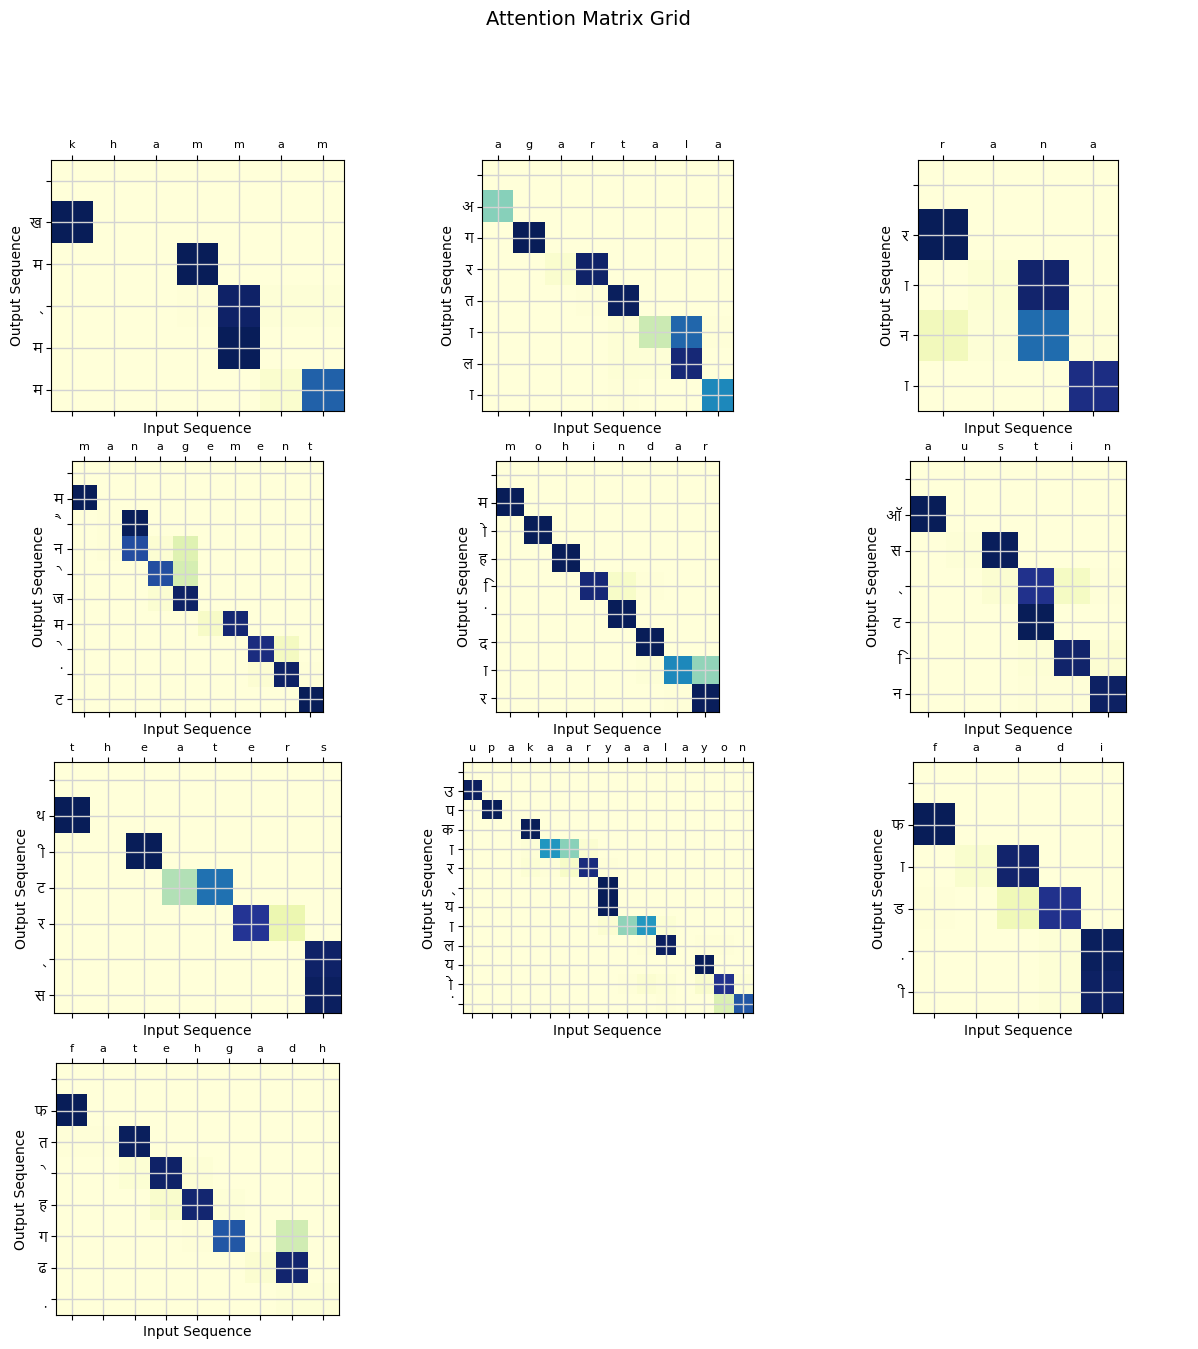

In [21]:
# Initialize lists to store inputs, predicted outputs, and corresponding attentions
attentions =[]
inputs=[]
outputs=[]

# Zip the test words and translations together
val=zip(preprocessed_data['test_words'], preprocessed_data['test_translations'])
# Randomly select 10 word-translation pairs for visualization
random_pairs = random.sample(list(val), 10)

# Enumerate over the randomly selected pairs
val=enumerate(random_pairs)
for i, (w, t) in val:
    # Extract the translation and word (remove end tokens)
    translation = t[:-1]
    word=w[:-1]
    
    # Use the trained model to predict the translation and capture attention
    output, attention = predict(trained_model, word, preprocessed_data, params)
    
    # Append the input word (without end token) to the inputs list
    inputs.append(w[:-1])
    
    # Append the predicted output (with a leading space for visualization) to the outputs list
    outputs.append(' '+output)
    
    # Append the attention matrix (limited to the length of the input word) to the attentions list
    attentions.append(attention[:, :, :(len(w[:-1]))])
    
# Visualize the attention matrices using a custom plotting function    
plot_attention_grid(inputs, outputs, attentions)


# TUNING HYPERPARAMETERS

In [23]:
# # Define individual hyperparameter values or ranges
# ne= {'values': [10]}
# ct = {'values': ['RNN', 'LSTM', 'GRU']}
# es = {'values': [128, 256, 512]}
# nl= {'values': [1, 2, 3]}
# dp= {'values': [0.3, 0.5, 0.7]}
# lr= {'values': [0.001, 0.005, 0.01, 0.1]}
# bs= {'values': [32, 64]}
# lp= {'values': [0.4, 0.5, 0.6]}
# bi= {'values': [True, False]}
# hs= {'values': [128, 256, 512]}
# opt={'values' : ['adam', 'sgd', 'rmsprop', 'adagrad']}
# bw = {'values': [1, 2, 3]}
# tf ={'values': [0.3, 0.5, 0.7]}

# # Define the sweep configuration dictionary
# sweep_config = {
#             'name': 'sweep 1 and 1.1 : random',
#             'method': 'random',
#             'metric': { 'goal': 'maximize','name': 'Accuracy'},
#             'parameters': 
#                 {
#                     'num_epochs': ne,
#                     'cell_type': ct,
#                     'embedding_size': es,
#                     'hidden_size': hs,
#                     'num_layers': nl ,
#                     'dropout': dp,
#                     'optimizer' : opt,
#                     'learning_rate': lr,
#                     'batch_size': bs,
#                     'teacher_fr' : tf,
#                     'length_penalty' : lp,
#                     'bi_dir' :bi ,
#                     'beam_width': bw
#                 }
#             }

In [24]:
# # Function to run sweep
# def run_sweep():
#     # Initialize Weights & Biases run for experiment tracking
#     init = wandb.init(project = 'DL-Assignment-3')
#     config = init.config
#     # Define parameters based on the configuration from Weights & Biases
#     params = {
#         'language' : 'hin',
#         'dataset_path' : '/kaggle/input/dl-ass3/aksharantar_sampled',
#         'num_epochs': config.num_epochs,
#         'cell_type': config.cell_type,
#         'embedding_size': config.embedding_size,
#         'hidden_size': config.hidden_size,
#         'num_layers_enc': config.num_layers,
#         'num_layers_dec': config.num_layers,
#         'dropout': config.dropout,
#         'optimizer' : config.optimizer,
#         'learning_rate': config.learning_rate,
#         'batch_size': config.batch_size,
#         'teacher_fr' : config.teacher_fr,
#         'length_penalty' : config.length_penalty,
#         'bi_dir' : config.bi_dir,
#         'beam_width' : config.beam_width,
#         'w_log' : 1
#     }
    
#     # Set the name of the Weights & Biases run based on the experiment configuration
#     wandb.run.name = f"c:{params['cell_type']}_e:{params['num_epochs']}_es:{params['embedding_size']}_hs:{params['hidden_size']}_nle:{params['num_layers_enc']}_nld:{params['num_layers_dec']}_o:{params['optimizer']}_lr:{params['learning_rate']}_bs:{params['batch_size']}_tf:{params['teacher_fr']}_lp:{params['length_penalty']}_b:{params['bi_dir']}_bw:{params['beam_width']}"
#     preprocessed_data = loadData(params)
#     tensors = create_tensor(preprocessed_data)
    
#     # Initialize the decoder, encoder, and seq2seq model based on the parameters
#     decoder = Decoder(params, preprocessed_data).to(device)
#     encoder = Encoder(params, preprocessed_data).to(device)
#     model = Seq2Seq(encoder, decoder, params, preprocessed_data).to(device) 
    
#     # Define the loss function (criterion) and optimizer based on the model and parameters
#     crit = nn.CrossEntropyLoss(ignore_index = 0)
#     opt = get_optim(model,params)
    
#     # Perform training and obtain validation accuracy with beam search
#     _, _, v_acc_beam = train(model, crit, opt, preprocessed_data, tensors, params)
    
#     # Log the validation accuracy with beam search to Weights & Biases
#     wandb.log({'Accuracy': v_acc_beam})

In [25]:
# # Initiate a hyperparameter sweep and obtain the sweep ID
# sweep_id = wandb.sweep(sweep_config, project='DL-Assignment-3')

# # Run the hyperparameter sweep using the defined `run_sweep` function as an agent
# # `count=25` specifies the number of runs (trials) to execute for the sweep
# wandb.agent(sweep_id, run_sweep, count = 25)

# # Finish the Weights & Biases run after completing the hyperparameter sweep
# wandb.finish()